## 1. Quá trình dự báo trên mô hình ARIMA

# Thêm thư viện

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pmdarima as pmd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

# Nạp dữ liệu từ file csv

In [2]:
df = pd.read_csv('../../../data/clean/btc_close.csv')
df.pop('volume')
df.pop('high')
df.pop('open')
df.pop('low')
df.pop('adjclose')
df = df.reset_index()
df['formatted_date'] = pd.to_datetime(df['formatted_date']).values.astype(np.int64)
df.set_index("formatted_date",inplace=True)
df.pop('index')
df.pop('Unnamed: 0')
df_close = df['close'].values.reshape(-1, 1)

df

,close
formatted_date,
1546300800000000000,3943.409424
1546387200000000000,3836.741211
1546473600000000000,3857.717529
1546560000000000000,3845.194580
1546646400000000000,4076.632568
...,...
1681948800000000000,27276.910156
1682035200000000000,27817.500000
1682121600000000000,27591.384766


# Chuẩn hóa dữ liệu

In [3]:
arima_sc = StandardScaler()

df_scaled = df.copy()
df_scaled['close'] = arima_sc.fit_transform(df_close)
df_scaled

,close
formatted_date,
1546300800000000000,-1.160522
1546387200000000000,-1.166824
1546473600000000000,-1.165585
1546560000000000000,-1.166324
1546646400000000000,-1.152651
...,...
1681948800000000000,0.218032
1682035200000000000,0.249971
1682121600000000000,0.236612


# Vẽ đồ thị

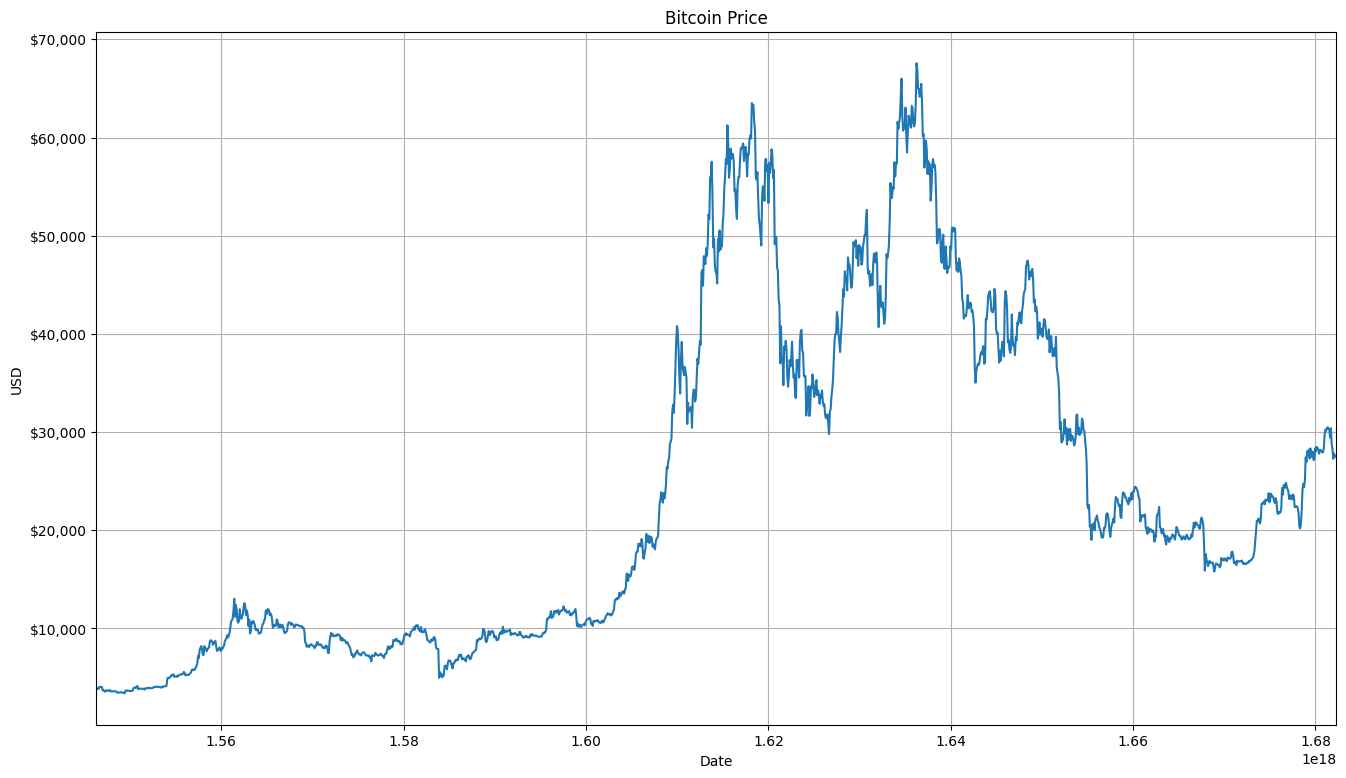

In [4]:
# Thư viện vẽ đồ thị
formatter = ticker.StrMethodFormatter('${x:,.0f}')

title = 'Bitcoin Price'
ylabel = 'USD'
xlabel = 'Date'

ax = df['close'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

# Tách dữ liệu thành tập train và test

In [5]:
train, test = df_scaled[:(int)(len(df_scaled) * 1)], df_scaled[(int)(len(df_scaled) * 1):]
index_test = df_scaled.index[:(int)(len(df_scaled) * 1)]
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (1575, 1)
test shape:  (0, 1)


# Hàm kiểm định chuỗi dừng

In [6]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    # .dropna() handles differenced data
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF test statistic', 'p-value',
              'Number of lags used', 'Number of observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    # .to_string() removes the line "dtype: float64"
    print(out.to_string())

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non stationary")

# Kiểm định tính dừng của chuỗi

In [7]:
adf_test(train['close'],'Bitcoin Price')

Augmented Dickey-Fuller Test: Bitcoin Price
ADF test statistic          -1.592909
p-value                      0.487155
Number of lags used         24.000000
Number of observations    1550.000000
critical value (1%)         -3.434576
critical value (5%)         -2.863406
critical value (10%)        -2.567764
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


nhận thấy p-value > 0.05, do đó chuỗi không phải là chuỗi dừng

# Tính sai phân bậc 1 (d = 1) của chuỗi để kiểm định tính dừng

<Axes: xlabel='formatted_date'>

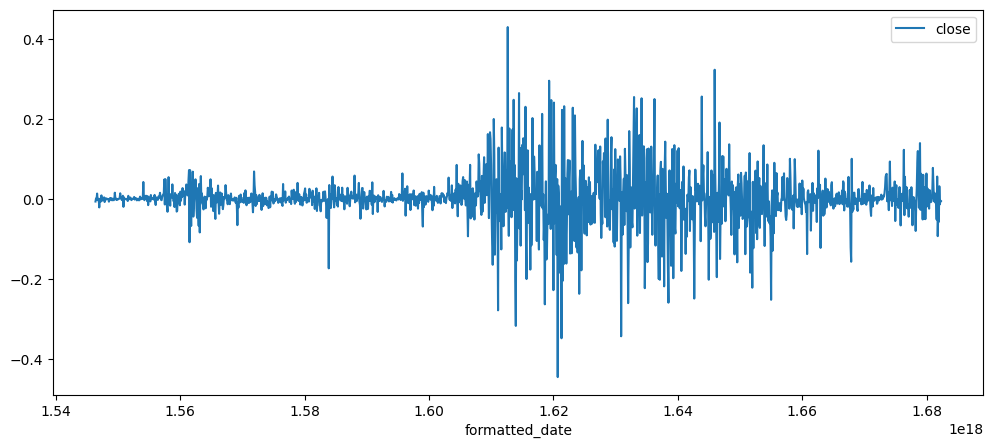

In [8]:
diff_1 = train.dropna().diff()
diff_1.plot(figsize=(12,5))

# Kiểm định tính dừng của chuỗi tại sai phân bậc 1

In [9]:
adf_test(diff_1, 'Bitcoin Price First Difference')

Augmented Dickey-Fuller Test: Bitcoin Price First Difference
ADF test statistic       -7.811727e+00
p-value                   7.040552e-12
Number of lags used       2.300000e+01
Number of observations    1.550000e+03
critical value (1%)      -3.434576e+00
critical value (5%)      -2.863406e+00
critical value (10%)     -2.567764e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Nhận thấy p-value < 0.05, do đó chuỗi có tính dừng tại sai phân bậc 1

In [10]:

def ArimaModel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              test="adf",
                              seasonal=False,
                              trace=True)
    return autoarima_model

In [11]:
import pickle
arima_model = ArimaModel(train)
arima_model.summary()
with open("../../../models/close/arima_model.pkl", "wb") as f:
        pickle.dump(arima_model, f)
    

    
    

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4175.193, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4180.647, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4180.049, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4180.022, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4182.348, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4178.091, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.295 seconds


# Dự đoán trên tập test

In [12]:
pred = arima_model.predict(len(train))
pred


1575    0.227564
1576    0.227564
1577    0.227564
1578    0.227564
1579    0.227564
          ...   
3145    0.227564
3146    0.227564
3147    0.227564
3148    0.227564
3149    0.227564
Length: 1575, dtype: float64

# Biến đổi giá trị dự đoán và thực tế về miền giá trị ban đầu

In [13]:
inv_test = arima_sc.inverse_transform(train.values.reshape(-1, 1))
inv_pred = arima_sc.inverse_transform(column_or_1d(pred).reshape(-1, 1))

# Vẽ đồ thị cho tập test và kết quả dự đoán

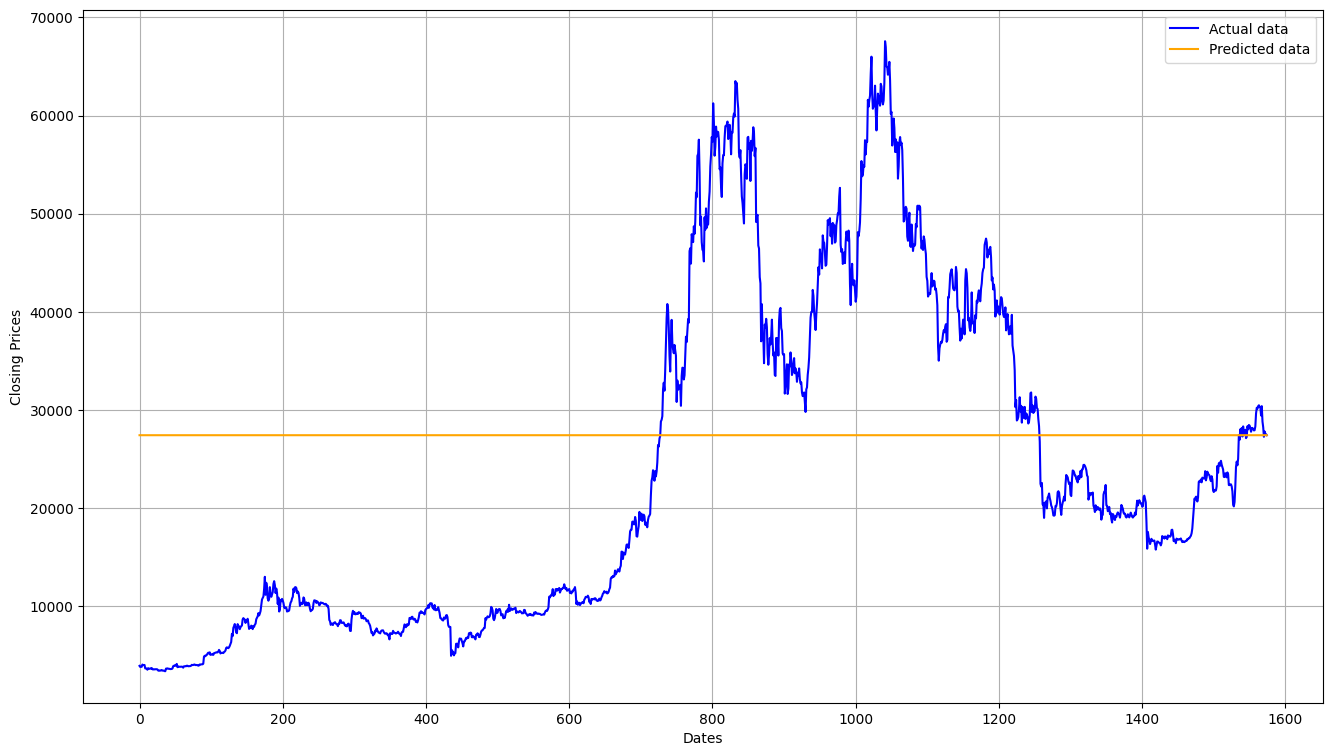

In [14]:
pred_series = pd.Series(pred, index=index_test)

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(inv_test, 'blue', label='Actual data')
plt.plot(inv_pred, 'orange', label='Predicted data')
plt.legend()

# Đánh giá mô hình

In [15]:
mae = mean_absolute_error(inv_test, inv_pred)
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_test, inv_pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 15495.46
MAPE: 136.26%
MSE: 301327732.71
RMSE: 17358.79
R2: -0.05


# Tạo một DataFrame là 'df_pred' để lưu kết quả dự đoán trên mô hình ARIMA

In [16]:
df_pred = pd.DataFrame(index=index_test)
df_pred['Actual'] = inv_test
df_pred['ARIMA'] = inv_pred
df_pred['Error'] = inv_test - inv_pred
df_pred

,Actual,ARIMA,Error
formatted_date,,,
1546300800000000000,3943.409424,27438.240234,-23494.830811
1546387200000000000,3836.741211,27438.240234,-23601.499023
1546473600000000000,3857.717529,27438.240234,-23580.522705
1546560000000000000,3845.194580,27438.240234,-23593.045654
1546646400000000000,4076.632568,27438.240234,-23361.607666
...,...,...,...
1681948800000000000,27276.910156,27438.240234,-161.330078
1682035200000000000,27817.500000,27438.240234,379.259766
1682121600000000000,27591.384766,27438.240234,153.144531


## 2. Quá trình dự đoán trên mô hình LSTM

# Tạo thêm một DataFrame để tiến hành dự đoán sai số trên mô hình LSTM

In [17]:
df_lstm = df_pred.copy()
df_lstm

,Actual,ARIMA,Error
formatted_date,,,
1546300800000000000,3943.409424,27438.240234,-23494.830811
1546387200000000000,3836.741211,27438.240234,-23601.499023
1546473600000000000,3857.717529,27438.240234,-23580.522705
1546560000000000000,3845.194580,27438.240234,-23593.045654
1546646400000000000,4076.632568,27438.240234,-23361.607666
...,...,...,...
1681948800000000000,27276.910156,27438.240234,-161.330078
1682035200000000000,27817.500000,27438.240234,379.259766
1682121600000000000,27591.384766,27438.240234,153.144531


# Vẽ đồ thị thể hiện sai số

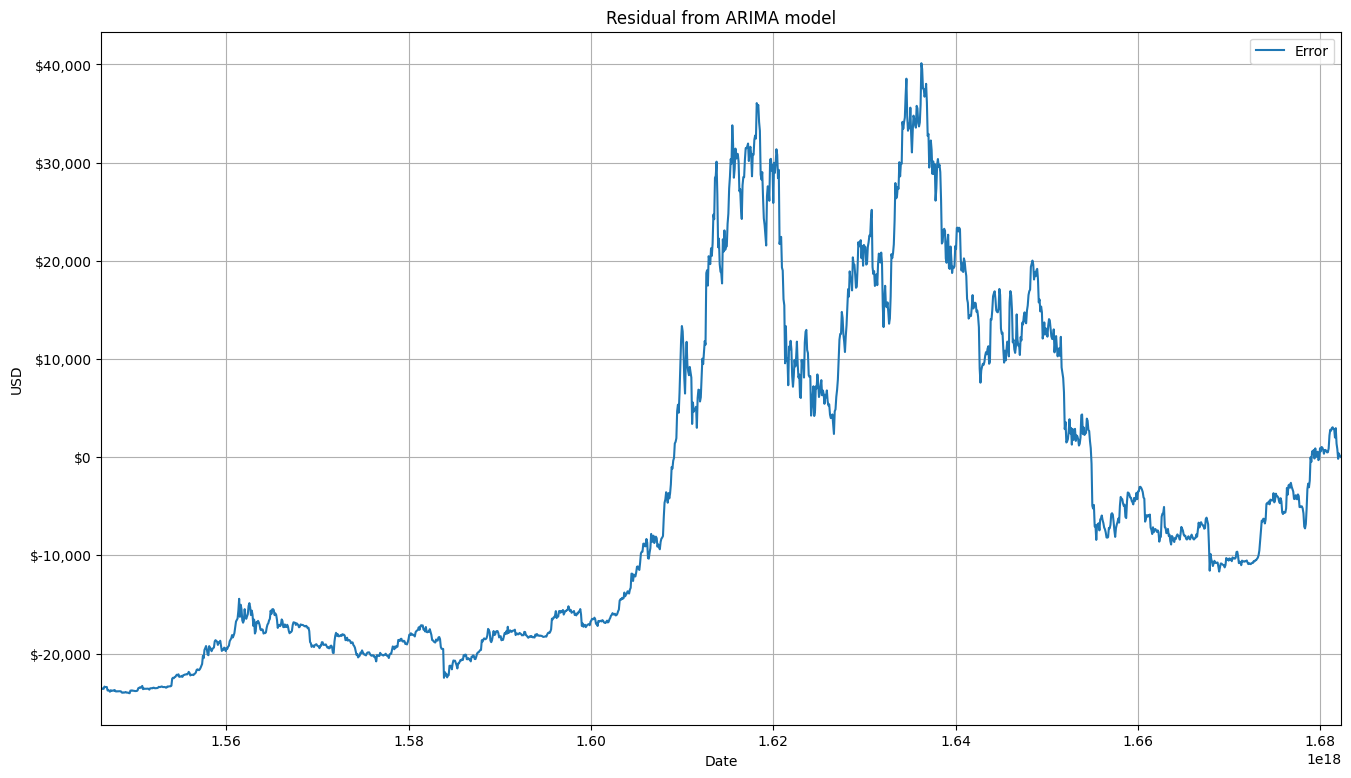

In [18]:
formatter = ticker.StrMethodFormatter('${x:,.0f}')

error = df_lstm[['Error']]
title = 'Residual from ARIMA model'
ylabel = 'USD'
xlabel = 'Date'

ax = error.plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

In [19]:
error = np.array(error)
error

array([[-23494.83081055],
       [-23601.49902344],
       [-23580.52270508],
       ...,
       [   153.14453125],
       [    87.09960938],
       [     0.        ]])

In [20]:
look_back = 3
x_total, y_total = [], []
for i in range(look_back, len(error)):
	x_total.append(error[i-look_back:i])
	y_total.append(error[i])
x_train = np.array(x_total[:len(error)])
y_train = np.array(y_total[:len(error)])

print("x_train",x_train.shape)
print("y_train",y_train.shape)


x_train (1572, 3, 1)
y_train (1572, 1)


In [21]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(x_train, y_train, epochs=300, verbose=1)
model.save("../../../models/close/lstm.h5")

Epoch 1/300
50/50 [==============================] - 2s 2ms/step - loss: 244935648.0000
Epoch 2/300
50/50 [==============================] - 0s 2ms/step - loss: 114794072.0000
Epoch 3/300
50/50 [==============================] - 0s 2ms/step - loss: 12068375.0000
Epoch 4/300
50/50 [==============================] - 0s 2ms/step - loss: 3754559.7500
Epoch 5/300
50/50 [==============================] - 0s 2ms/step - loss: 2955326.0000
Epoch 6/300
50/50 [==============================] - 0s 2ms/step - loss: 2292003.0000
Epoch 7/300
50/50 [==============================] - 0s 2ms/step - loss: 2244686.5000
Epoch 8/300
50/50 [==============================] - 0s 2ms/step - loss: 2200987.2500
Epoch 9/300
50/50 [==============================] - 0s 2ms/step - loss: 2293455.7500
Epoch 10/300
50/50 [==============================] - 0s 2ms/step - loss: 2551795.0000
Epoch 11/300
50/50 [==============================] - 0s 2ms/step - loss: 3611523.2500
Epoch 12/300
50/50 [===========================

In [22]:
model = load_model("../../../models/close/lstm.h5")
error_pred = model.predict(x_train)
error_pred

50/50 [==============================] - 0s 1ms/step


array([[-23488.045  ],
       [-23499.406  ],
       [-23273.697  ],
       ...,
       [   183.46672],
       [   219.38454],
       [   -37.14848]], dtype=float32)

In [23]:
df_lstm = df_lstm.copy().head(len(error_pred))
df_lstm['Error Prediction'] = error_pred
df_lstm

,Actual,ARIMA,Error,Error Prediction
formatted_date,,,,
1546300800000000000,3943.409424,27438.240234,-23494.830811,-23488.044922
1546387200000000000,3836.741211,27438.240234,-23601.499023,-23499.406250
1546473600000000000,3857.717529,27438.240234,-23580.522705,-23273.697266
1546560000000000000,3845.194580,27438.240234,-23593.045654,-23318.539062
1546646400000000000,4076.632568,27438.240234,-23361.607666,-23315.083984
...,...,...,...,...
1681689600000000000,30397.552734,27438.240234,2959.312500,353.864532
1681776000000000000,28822.679688,27438.240234,1384.439453,254.748932
1681862400000000000,28245.988281,27438.240234,807.748047,183.466721


In [24]:
df_lstm['ARIMA_LSTM'] = df_lstm['ARIMA'] + df_lstm['Error Prediction']
df_lstm

,Actual,ARIMA,Error,Error Prediction,ARIMA_LSTM
formatted_date,,,,,
1546300800000000000,3943.409424,27438.240234,-23494.830811,-23488.044922,3950.195312
1546387200000000000,3836.741211,27438.240234,-23601.499023,-23499.406250,3938.833984
1546473600000000000,3857.717529,27438.240234,-23580.522705,-23273.697266,4164.542969
1546560000000000000,3845.194580,27438.240234,-23593.045654,-23318.539062,4119.701172
1546646400000000000,4076.632568,27438.240234,-23361.607666,-23315.083984,4123.156250
...,...,...,...,...,...
1681689600000000000,30397.552734,27438.240234,2959.312500,353.864532,27792.104767
1681776000000000000,28822.679688,27438.240234,1384.439453,254.748932,27692.989166
1681862400000000000,28245.988281,27438.240234,807.748047,183.466721,27621.706955


# Vẽ đồ thị

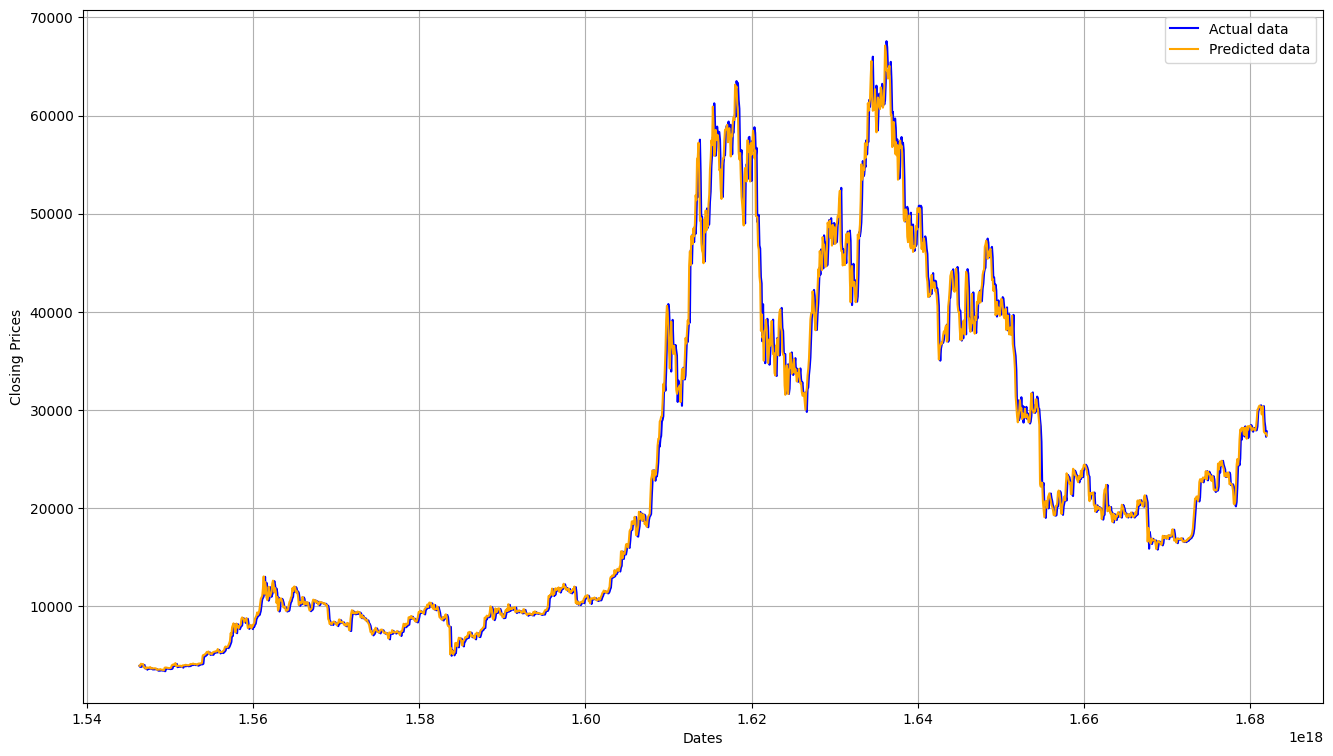

In [25]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_lstm['Actual'], 'blue', label='Actual data')
plt.plot(df_lstm['ARIMA_LSTM'], 'orange', label='Predicted data')
plt.legend()

# Đánh giá mô hình

In [26]:
mae = mean_absolute_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
mape = mean_absolute_percentage_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
mse = mean_squared_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
rmse = np.sqrt(mse)
r2 = r2_score(df_lstm.Actual, df_lstm.ARIMA_LSTM)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 890.13
MAPE: 3.68%
MSE: 2149480.43
RMSE: 1466.11
R2: 0.99
